In [1]:
!nvidia-smi

Wed Jan  4 16:15:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import data
import numpy as np

In [3]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dir = '/content/drive/MyDrive/data_sd_new/train'
valid_dir = '/content/drive/MyDrive/data_sd_new/val'
test_dir = '/content/drive/MyDrive/data_sd_new/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2012 files belonging to 36 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 395 files belonging to 36 classes.


In [5]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 108 files belonging to 36 classes.


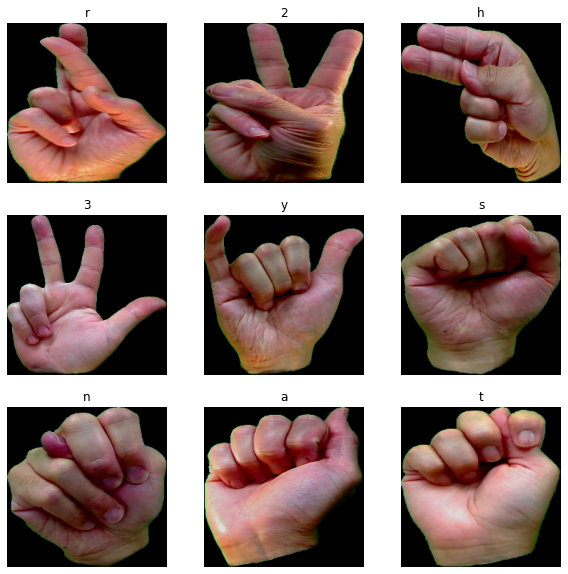

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.7),
  tf.keras.layers.RandomBrightness(factor=0.7),
  tf.keras.layers.RandomRotation(0.1)
])

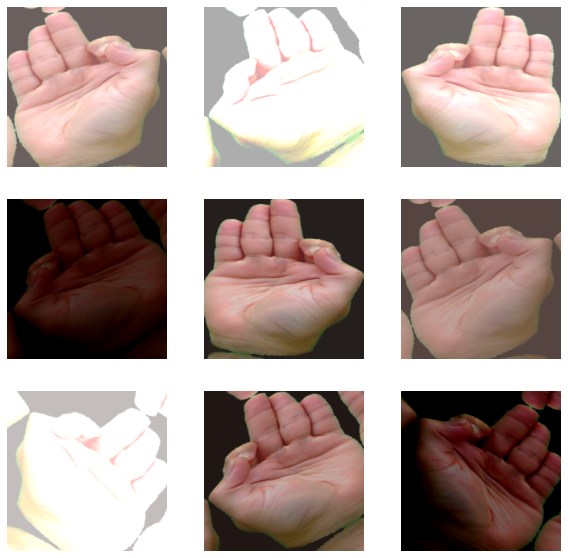

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [13]:
rescale = tf.keras.layers.Rescaling(1./255)

In [14]:
# Create the base model from the pre-trained model EfficientNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

115263384/115263384 [==============================] - 0s 0us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [19]:
prediction_layer = tf.keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 36)


In [20]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 36)                73764     
                                                             

In [23]:
len(model.trainable_variables)

2

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  577


In [25]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

25/25 [==============================] - 126s 3s/step - loss: 3.6483 - accuracy: 0.0430


In [26]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


126/126 [==============================] - 364s 3s/step - loss: 3.5139 - accuracy: 0.0636 - val_loss: 3.3431 - val_accuracy: 0.1899
Epoch 2/20
126/126 [==============================] - 33s 255ms/step - loss: 3.2827 - accuracy: 0.1600 - val_loss: 3.1337 - val_accuracy: 0.3241
Epoch 3/20
126/126 [==============================] - 35s 275ms/step - loss: 3.0866 - accuracy: 0.2455 - val_loss: 2.9543 - val_accuracy: 0.3924
Epoch 4/20
126/126 [==============================] - 33s 259ms/step - loss: 2.9195 - accuracy: 0.3171 - val_loss: 2.8014 - val_accuracy: 0.4127
Epoch 5/20
126/126 [==============================] - 33s 256ms/step - loss: 2.7898 - accuracy: 0.3633 - val_loss: 2.6683 - val_accuracy: 0.4658
Epoch 6/20
126/126 [==============================] - 33s 259ms/step - loss: 2.6446 - accuracy: 0.3956 - val_loss: 2.5458 - val_accuracy: 0.5190
Epoch 7/20
126/126 [==============================] - 33s 257ms/step - loss: 2.5388 - accuracy: 0.4533 - val_loss: 2.4392 - val_accuracy: 0.503

Took 18 mins to run epoch 1 to 20

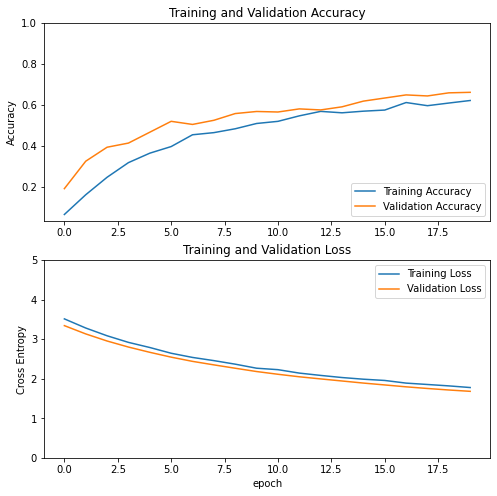

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('train_val_acc_loss_efficientnetB5_before.png', dpi=300)
plt.show()

In [29]:
base_model.trainable = True

In [30]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

In [31]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 36)                73764     
                                                             

In [33]:
len(model.trainable_variables)

506

In [34]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


126/126 [==============================] - 134s 770ms/step - loss: 1.1530 - accuracy: 0.6923 - val_loss: 0.5701 - val_accuracy: 0.8506
Epoch 21/40
126/126 [==============================] - 93s 737ms/step - loss: 0.7650 - accuracy: 0.7868 - val_loss: 0.3608 - val_accuracy: 0.8962
Epoch 22/40
126/126 [==============================] - 95s 746ms/step - loss: 0.6355 - accuracy: 0.8042 - val_loss: 0.2562 - val_accuracy: 0.9139
Epoch 23/40
126/126 [==============================] - 93s 737ms/step - loss: 0.4967 - accuracy: 0.8489 - val_loss: 0.2001 - val_accuracy: 0.9291
Epoch 24/40
126/126 [==============================] - 93s 736ms/step - loss: 0.4482 - accuracy: 0.8554 - val_loss: 0.1784 - val_accuracy: 0.9342
Epoch 25/40
126/126 [==============================] - 94s 745ms/step - loss: 0.3914 - accuracy: 0.8748 - val_loss: 0.1583 - val_accuracy: 0.9367
Epoch 26/40
126/126 [==============================] - 94s 740ms/step - loss: 0.3540 - accuracy: 0.8817 - val_loss: 0.1417 - val_accura

Took 42 mins to run epoch 20 to 40. 

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

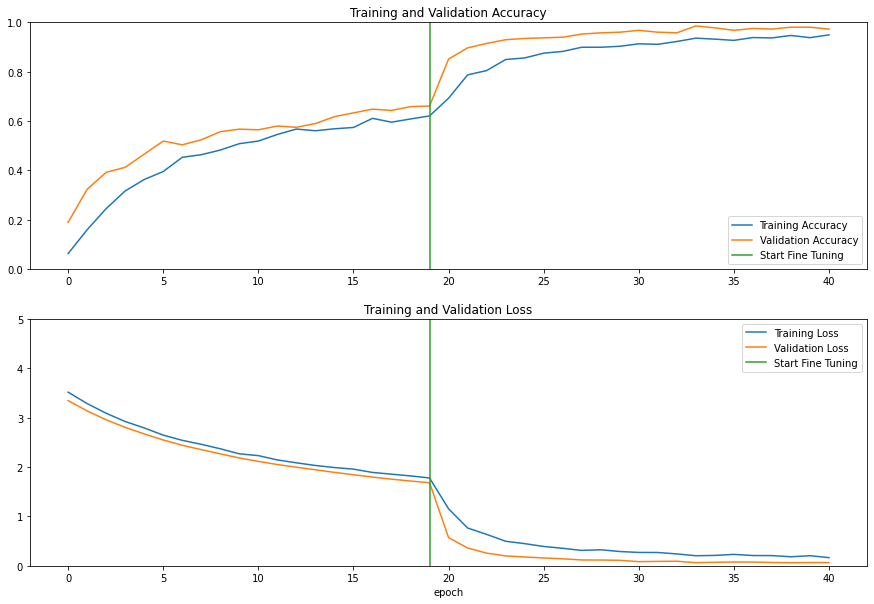

In [36]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('train_val_acc_loss_efficientnetB5_after.png', dpi=300)
plt.show()

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 20s 115ms/step - loss: 0.0577 - accuracy: 0.9815
Test accuracy : 0.9814814925193787


Accuracy for Signer Dependent using EfficientNet B5 is 98.15%

In [38]:
img_height = 224
img_width = 224

img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/output_ori/nine.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 4s 4s/step
This image most likely belongs to 9 with a 77.50 percent confidence.


In [39]:
# from tensorflow.keras.models import load_model

model.save('transfer_learning_efficientnetb5_sd.h5')

model.save('transfer_learning_efficientnet_b5_sd')